device:  mps
Training network for time t_1 = 0.100 ...
  Epoch 200, Loss = 1.34287e-04
  Epoch 400, Loss = 1.71477e-04
  Epoch 600, Loss = 1.58495e-04
  Epoch 800, Loss = 1.09364e-04
  Epoch 1000, Loss = 1.36066e-04
Training network for time t_2 = 0.200 ...
  Epoch 200, Loss = 7.68078e-05
  Epoch 400, Loss = 6.13398e-05
  Epoch 600, Loss = 6.01183e-05
  Epoch 800, Loss = 6.94148e-05
  Epoch 1000, Loss = 7.06985e-05
Training network for time t_3 = 0.300 ...
  Epoch 200, Loss = 6.37454e-05
  Epoch 400, Loss = 3.36945e-05
  Epoch 600, Loss = 3.52889e-05
  Epoch 800, Loss = 3.02823e-05
  Epoch 1000, Loss = 2.70680e-05
Training network for time t_4 = 0.400 ...
  Epoch 200, Loss = 2.03053e-05
  Epoch 400, Loss = 1.98607e-05
  Epoch 600, Loss = 1.53626e-05
  Epoch 800, Loss = 1.62474e-05
  Epoch 1000, Loss = 2.29396e-05
Training network for time t_5 = 0.500 ...
  Epoch 200, Loss = 1.19631e-05
  Epoch 400, Loss = 9.20606e-06
  Epoch 600, Loss = 1.02827e-05
  Epoch 800, Loss = 6.66362e-06
  Epo

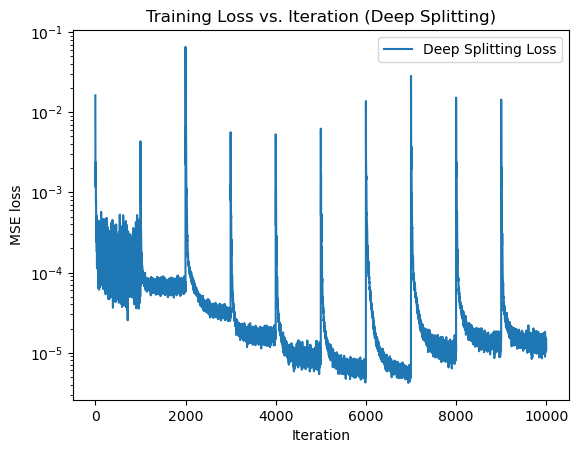

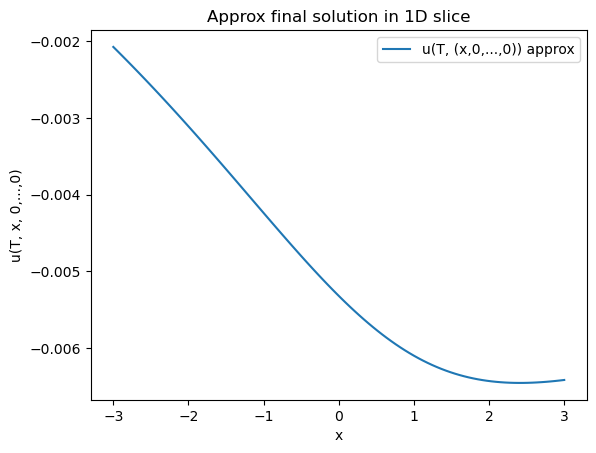

In [3]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

#======================================================================
#                    Device configuration
#======================================================================

# Device to use for computation
device = None

if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")
    
    # Set CPU as the device for doing the computation
    device = torch.device("cpu")
else:
    # Set MPS(Metal programming framework) as the device for doing the computation
    device = torch.device("mps")
print("device: ", device)
#======================================================================
#======================================================================

#-------------------------------------------------
#            1. Hyperparameters
#-------------------------------------------------
pde_dimension = 10   # dimension of x
alpha         = 1.0  # fractional exponent
T             = 1.0  # final time
N_time_steps  = 10   # number of time splits
batch_size    = 1024 # batch size for Monte Carlo
lr_per_step   = 1e-3 # learning rate for each step
epochs_per_step = 1000  # how many epochs to train each time-step network
hidden_width  = 64   # width of hidden layers

#-------------------------------------------------
#   2. Generate alpha-stable increments in 10D
#      (For alpha=1, we do Cauchy(0, dt^(1/alpha)).
#      For alpha=2, standard normal with scale sqrt(dt).
#      You can generalize as needed.)
#-------------------------------------------------
def sample_alpha_stable(batch_size, dim, alpha, dt, device):
    """
    Return shape (batch_size, dim) of i.i.d. alpha-stable increments
    with 'time step' dt.  For demonstration, we implement:
       alpha=2.0 -> Gaussian with variance = 2 * dt   (symmetric stable)
       alpha=1.0 -> Cauchy(0, dt)
    """
    if alpha == 2.0:
        # Symmetric alpha-stable with alpha=2 is just Brownian motion,
        # so increments ~ Normal(0, sqrt(2*dt)).
        # If you want precisely "(-Delta)^(alpha/2)", you may need a
        # factor.  We'll do scale = sqrt(2 * dt) for demonstration.
        scale = (2.0 * dt)**0.5
        return scale * torch.randn(batch_size, dim, device=device)
    elif alpha == 1.0:
        # Symmetric Cauchy(0, scale=dt).  PyTorch has no built-in Cauchy
        # prior to 1.13, but we can do it via the StudentT with 1 degree
        # of freedom or define our own. For simplicity:
        dist = torch.distributions.cauchy.Cauchy(loc=0.0, scale=dt)
        return dist.sample((batch_size, dim)).to(device)
    else:
        raise NotImplementedError("sample_alpha_stable only handles alpha=1 or alpha=2 here.")

#-------------------------------------------------
# 3. Initial Condition
#    u(0,x) = exp( -||x||^2 )
#-------------------------------------------------
def initial_condition(x):
    # x shape = (batch_size, pde_dimension)
    return torch.exp(- torch.sum(x**2, dim=1, keepdim=True))

#-------------------------------------------------
# 4. Neural Nets
#   We'll store N+1 networks: net[0]..net[N].
#   net[0] is just the known initial condition (can code as a function),
#   or we can store it as a "frozen" neural net if we want.
#-------------------------------------------------
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, output_dim)
        )
    def forward(self, x):
        return self.net(x)

# We create a Python list of length N+1.  net[0] is not a real net
# but a Python function for the init cond.  net[1..N] are trainable nets.
nets = [None]*(N_time_steps+1)

# net[0]: the exact init condition, stored as a Python lambda for convenience.
# In other contexts, you could store a "frozen" NN that you never train.
nets[0] = initial_condition

# net[k]: MLP for u(t_k, x)
for k in range(1, N_time_steps+1):
    nets[k] = MLP(input_dim=pde_dimension, hidden_dim=hidden_width).to(device)

#-------------------------------------------------
# 5. Training Loop for Deep Splitting
#    We do time steps k = 0..N-1, to get net[k+1].
#    At each step, net[k+1](x) ~ E[ net[k](x + Y) ].
#-------------------------------------------------
time_grid = np.linspace(0, T, N_time_steps+1)  # e.g. 0,0.1,...,1.0
dt = float(T / N_time_steps)

# We'll keep track of losses for visualization
training_losses = []

for k in range(N_time_steps):
    print(f"Training network for time t_{k+1} = {time_grid[k+1]:.3f} ...")
    optimizer = torch.optim.Adam(nets[k+1].parameters(), lr=lr_per_step)

    for epoch in range(epochs_per_step):
        optimizer.zero_grad()

        # 1) sample x ~ Normal(0,1) for 10D (or another distribution)
        x_batch = torch.randn(batch_size, pde_dimension, device=device)

        # 2) sample M alpha-stable increments (e.g. just 1 per x in this code).
        #    Alternatively, you can average multiple increments to reduce variance.
        Y = sample_alpha_stable(batch_size, pde_dimension, alpha, dt, device)

        # 3) Evaluate the "previous" net at x+Y
        #    net[k] might be a function (k=0) or an MLP (k>0).
        if k == 0:
            # net[0] is the known initial condition function
            u_prev = nets[k](x_batch + Y)  # call initial_condition
        else:
            u_prev = nets[k](x_batch + Y)

        # 4) We want net[k+1](x) \approx E[u_prev].  Here we do it with 1 sample
        #    per x. If you want a better Monte Carlo estimate, you can sample M>1
        #    increments per x and average.  We'll keep it simple.
        u_target = u_prev.detach()  # we treat the previous net's value as "target"

        # Evaluate the new net
        u_new = nets[k+1](x_batch)

        # 5) MSE loss
        loss = torch.mean((u_new - u_target)**2)
        loss.backward()
        optimizer.step()

        training_losses.append(loss.item())

        if (epoch+1) % 200 == 0:
            print(f"  Epoch {epoch+1}, Loss = {loss.item():.5e}")

print("Deep Splitting training complete.")

#-------------------------------------------------
# 6. The final network nets[N_time_steps] approximates u(T,x).
#    If you want the solution at some 0 < t < T, you can use
#    nets[k] for whichever step is closest.
#-------------------------------------------------

# Plot the loss curve
plt.figure()
plt.plot(training_losses, label="Deep Splitting Loss")
plt.xlabel("Iteration")
plt.ylabel("MSE loss")
plt.yscale("log")
plt.title("Training Loss vs. Iteration (Deep Splitting)")
plt.legend()
plt.show()

#-------------------------------------------------
# Quick Check:  Compare final net to exact solution
# at time T in some small 1D slice, if alpha=2 (for instance)
# or just see if it decays as expected.  There's no closed form
# for alpha=1 except through integral representations, so
# we'll just illustrate that the network yields a "reasonable" shape.
#-------------------------------------------------
def evaluate_final_net_1d_slice(x_vals_1d):
    """
    Evaluate the final net at x = (x1, 0,0,...,0).
    We'll see if it decays with |x|.
    """
    # net[T] is nets[N_time_steps]
    # We'll do an explicit CPU evaluation for plotting
    x_tensor = torch.zeros((len(x_vals_1d), pde_dimension))
    x_tensor[:,0] = torch.tensor(x_vals_1d)
    x_tensor = x_tensor.to(device)

    with torch.no_grad():
        u_approx = nets[N_time_steps](x_tensor).cpu().numpy().ravel()
    return u_approx

x_range = np.linspace(-3, 3, 100)
u_plot = evaluate_final_net_1d_slice(x_range)

plt.figure()
plt.plot(x_range, u_plot, label="u(T, (x,0,...,0)) approx")
plt.title("Approx final solution in 1D slice")
plt.xlabel("x")
plt.ylabel("u(T, x, 0,...,0)")
plt.legend()
plt.show()


Using device: mps
Training network k=1, time = 0.100
  Epoch 200, Loss = 1.86295e-04
  Epoch 400, Loss = 9.84986e-05
  Epoch 600, Loss = 3.90436e-05
  Epoch 800, Loss = 1.53133e-04
  Epoch 1000, Loss = 8.54094e-05
Training network k=2, time = 0.200
  Epoch 200, Loss = 1.57837e-04
  Epoch 400, Loss = 1.34457e-04
  Epoch 600, Loss = 8.18023e-05
  Epoch 800, Loss = 7.93559e-05
  Epoch 1000, Loss = 7.05497e-05
Training network k=3, time = 0.300
  Epoch 200, Loss = 1.68985e-04
  Epoch 400, Loss = 1.51589e-04
  Epoch 600, Loss = 1.26095e-04
  Epoch 800, Loss = 9.63867e-05
  Epoch 1000, Loss = 9.42030e-05
Training network k=4, time = 0.400
  Epoch 200, Loss = 9.20997e-05
  Epoch 400, Loss = 6.70273e-05
  Epoch 600, Loss = 5.04908e-05
  Epoch 800, Loss = 4.50665e-05
  Epoch 1000, Loss = 5.15808e-05
Training network k=5, time = 0.500
  Epoch 200, Loss = 6.33968e-05
  Epoch 400, Loss = 3.43284e-05
  Epoch 600, Loss = 3.59967e-05
  Epoch 800, Loss = 4.22642e-05
  Epoch 1000, Loss = 2.83296e-05
Tr

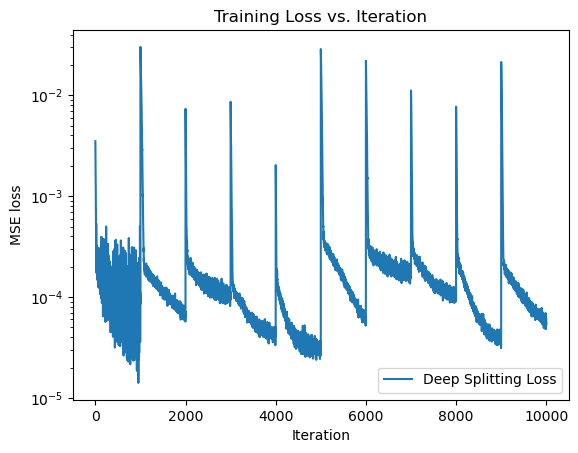

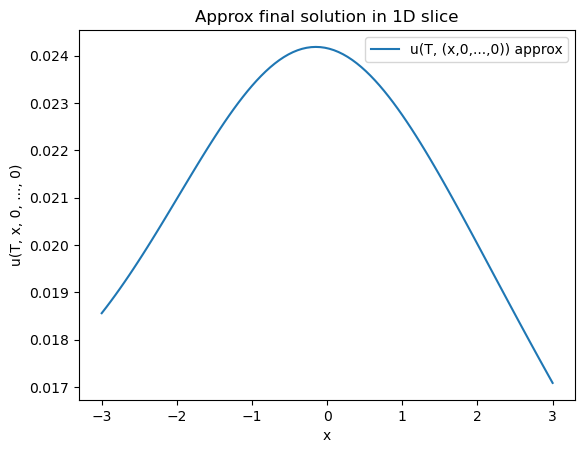

Done! Saved predictions in dsm_approx_solutions.json


In [19]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import json
import math
import os

#======================================================================
#                    Device configuration
#======================================================================

if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")
    device = torch.device("cpu")
else:
    device = torch.device("mps")

print("Using device:", device)

#-------------------------------------------------
#            1. Hyperparameters
#-------------------------------------------------
pde_dimension   = 10      # dimension of x
alpha           = 1.5     # fractional exponent
T               = 1.0     # final time
N_time_steps    = 10      # number of time splits
batch_size      = 1024    # batch size for Monte Carlo
lr_per_step     = 1e-4    # learning rate (adjust if needed)
epochs_per_step = 1000    # epochs per time-split
hidden_width    = 64      # MLP hidden layer width
max_grad_norm   = 1.0     # clip gradients for stability

# Clamping constants for alpha-stable increments
CLAMP_VALUE = 1e5   
EPS         = 1e-9  # small epsilon to avoid division by zero

#-------------------------------------------------
#   2. Generate alpha-stable increments in 10D
#-------------------------------------------------
def sample_alpha_stable(batch_size, dim, alpha, dt, device):
    """
    Returns shape (batch_size, dim) of i.i.d. symmetric alpha-stable increments
    with 'time step' dt. We clamp outliers to avoid NaNs.
    """
    # alpha=2.0 -> Gaussian
    if abs(alpha - 2.0) < 1e-12:
        scale = math.sqrt(2.0 * dt)
        Y = scale * torch.randn(batch_size, dim, device=device, dtype=torch.float32)
        return torch.clamp(Y, -CLAMP_VALUE, CLAMP_VALUE)

    # alpha=1.0 -> Cauchy
    elif abs(alpha - 1.0) < 1e-12:
        # Cauchy(0, dt) = dt * tan(pi * (U-0.5))
        U = torch.rand(batch_size, dim, device=device, dtype=torch.float32)
        Y = dt * torch.tan(math.pi * (U - 0.5))
        # convert infinities/NaNs to finite
        Y = torch.nan_to_num(Y, nan=0.0, posinf=CLAMP_VALUE, neginf=-CLAMP_VALUE)
        Y = torch.clamp(Y, -CLAMP_VALUE, CLAMP_VALUE)
        return Y

    # alpha=1.5 -> Chambers–Mallows–Stuck
    elif abs(alpha - 1.5) < 1e-12:
        scale = (2.0 * dt)**(1.0 / alpha)

        # We'll do a single pass, but clamp afterwards
        U = (torch.rand(batch_size, dim, device=device, dtype=torch.float32) - 0.5)*math.pi
        E = -torch.log(torch.rand(batch_size, dim, device=device, dtype=torch.float32) + EPS)

        # cos(U) safely
        cos_U = torch.cos(U)
        # avoid perfect zeros or infinities
        cos_U = cos_U.clamp(min=-1.0+EPS, max=1.0-EPS)

        Z_num = torch.sin(alpha * U)
        # (cos(U))^(1/alpha)
        cos_part = cos_U.abs()**(1.0/alpha)*torch.sign(cos_U)**(1.0/alpha)

        # Chambers factor
        #   factor = [cos(U - alpha*U) / E]^((1-alpha)/alpha)
        cos_diff = torch.cos(U - alpha*U).clamp(min=-1.0, max=1.0)
        ratio = cos_diff / (E + EPS)
        ratio = torch.nan_to_num(ratio, nan=0.0, posinf=CLAMP_VALUE, neginf=-CLAMP_VALUE)
        factor = ratio**((1.0 - alpha)/alpha)

        Z_den = cos_part + EPS
        Z = (Z_num / Z_den) * factor

        Z = torch.nan_to_num(Z, nan=0.0, posinf=CLAMP_VALUE, neginf=-CLAMP_VALUE)
        Y = scale * Z
        Y = torch.clamp(Y, -CLAMP_VALUE, CLAMP_VALUE)
        return Y

    else:
        raise NotImplementedError("sample_alpha_stable only handles alpha=1.0, 1.5, or 2.0.")

#-------------------------------------------------
# 3. Initial Condition
#    u(0,x) = exp( -||x||^2 )
#-------------------------------------------------
def initial_condition(x):
    # shape (batch_size, pde_dimension)
    return torch.exp(- torch.sum(x**2, dim=1, keepdim=True))

#-------------------------------------------------
# 4. Neural Nets
#-------------------------------------------------
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)

# Create list of networks: net[0] is the initial condition function; net[1..N] are trainable.
nets = [None]*(N_time_steps+1)
nets[0] = initial_condition  # a Python function, not a nn.Module

for k in range(1, N_time_steps+1):
    nets[k] = MLP(input_dim=pde_dimension, hidden_dim=hidden_width, output_dim=1).to(device)

#-------------------------------------------------
# 5. Training Loop (Deep Splitting)
#-------------------------------------------------
time_grid = np.linspace(0, T, N_time_steps+1, dtype=np.float32)  # e.g. [0, 0.1, 0.2, ..., 1.0]
dt = T / N_time_steps

training_losses = []

for k in range(N_time_steps):
    print(f"Training network k={k+1}, time = {time_grid[k+1]:.3f}")
    optimizer = torch.optim.Adam(nets[k+1].parameters(), lr=lr_per_step)

    for epoch in range(epochs_per_step):
        optimizer.zero_grad()

        # 1) sample x ~ Normal(0,1) in R^pde_dimension
        x_batch = torch.randn(batch_size, pde_dimension, device=device, dtype=torch.float32)
        # 2) sample alpha-stable increments
        Y = sample_alpha_stable(batch_size, pde_dimension, alpha, dt, device)

        # 3) Evaluate net[k] at x+Y
        # net[0] is initial_condition (a function), net[k] is MLP
        u_prev = nets[k](x_batch + Y)

        # 4) target ~ E[u_prev]. With 1 sample, we treat it as direct.
        u_target = u_prev.detach()

        # 5) net[k+1](x) -> should match u_target
        u_new = nets[k+1](x_batch)
        loss = torch.mean((u_new - u_target)**2)

        # If we get a NaN, skip
        if torch.isnan(loss):
            print(f"  [Warning] got NaN loss at epoch {epoch}, skipping backward.")
            continue

        loss.backward()
        # gradient clip to avoid blow-ups
        torch.nn.utils.clip_grad_norm_(nets[k+1].parameters(), max_grad_norm)
        optimizer.step()

        training_losses.append(loss.item())

        # Print occasionally
        if (epoch+1) % 200 == 0:
            print(f"  Epoch {epoch+1}, Loss = {loss.item():.5e}")

print("Deep Splitting training complete.")

#-------------------------------------------------
# 6. Plot the training loss
#-------------------------------------------------
plt.figure()
plt.plot(training_losses, label="Deep Splitting Loss")
plt.xlabel("Iteration")
plt.ylabel("MSE loss")
plt.yscale("log")
plt.title("Training Loss vs. Iteration")
plt.legend()
plt.show()

#-------------------------------------------------
# 7. Evaluate final net in 1D slice
#-------------------------------------------------
def evaluate_final_net_1d_slice(x_vals_1d):
    x_vals_1d = np.array(x_vals_1d, dtype=np.float32)
    x_tensor  = torch.zeros((len(x_vals_1d), pde_dimension), device=device, dtype=torch.float32)
    x_tensor[:, 0] = torch.tensor(x_vals_1d, device=device, dtype=torch.float32)

    with torch.no_grad():
        u_approx = nets[N_time_steps](x_tensor)
    return u_approx.cpu().numpy().ravel()

x_range = np.linspace(-3, 3, 100, dtype=np.float32)
u_plot = evaluate_final_net_1d_slice(x_range)

plt.figure()
plt.plot(x_range, u_plot, label="u(T, (x,0,...,0)) approx")
plt.title("Approx final solution in 1D slice")
plt.xlabel("x")
plt.ylabel("u(T, x, 0, ..., 0)")
plt.legend()
plt.show()

#-------------------------------------------------
# 8. Evaluate on test_data.json
#-------------------------------------------------
def approximate_solution_for_test_data(nets, dt,
                                       filename_in="test_data.json",
                                       filename_out="dsm_approx_solutions.json"):
    """
    Reads time (t) and spatial points (x) from 'test_data.json',
    evaluates the approximate solution for each (t_i, x_i),
    and saves the results into 'dsm_approx_solutions.json'.
    """
    with open(filename_in, "r") as f:
        test_data = json.load(f)

    t_list = np.array(test_data["t"], dtype=np.float32)   # shape (N,)
    x_list = np.array(test_data["x"], dtype=np.float32)   # shape (N, pde_dimension)

    solutions = np.zeros(len(t_list), dtype=np.float32)

    with torch.no_grad():
        for i in range(len(t_list)):
            # clamp index to valid range
            k = int(round(t_list[i] / dt))
            k = max(0, min(k, N_time_steps))

            # shape (1, pde_dimension), on same device as net
            x_torch = torch.from_numpy(x_list[i]).unsqueeze(0).float().to(device)

            # Evaluate the appropriate net
            if k == 0:
                val = nets[0](x_torch)  # initial_condition function
            else:
                val = nets[k](x_torch)  # MLP

            solutions[i] = val.cpu().numpy().flatten()[0]

    # Save to JSON
    out_dict = {"approx_solutions": solutions.tolist()}
    with open(filename_out, "w") as f:
        json.dump(out_dict, f, indent=2)

    return solutions

#-------------------------------------------------
# 9. Example usage
#-------------------------------------------------
if __name__ == "__main__":
    # Evaluate and save predictions using the trained nets
    preds = approximate_solution_for_test_data(
        nets=nets,
        dt=dt,
        filename_in="test_data.json",
        filename_out="dsm_approx_solutions.json"
    )
    print("Done! Saved predictions in dsm_approx_solutions.json")


Using device: mps
Training net[1], time ~ 0.050
  Epoch 500/2000, Loss=1.12146e-04
  Epoch 1000/2000, Loss=7.71838e-05
  Epoch 1500/2000, Loss=5.48447e-05
  Epoch 2000/2000, Loss=1.01822e-04
Training net[2], time ~ 0.100
  Epoch 500/2000, Loss=1.11678e-05
  Epoch 1000/2000, Loss=7.74730e-06
  Epoch 1500/2000, Loss=6.39607e-06
  Epoch 2000/2000, Loss=5.66193e-06
Training net[3], time ~ 0.150
  Epoch 500/2000, Loss=1.00451e-05
  Epoch 1000/2000, Loss=5.86812e-06
  Epoch 1500/2000, Loss=4.56061e-06
  Epoch 2000/2000, Loss=4.14977e-06
Training net[4], time ~ 0.200
  Epoch 500/2000, Loss=6.52942e-06
  Epoch 1000/2000, Loss=4.04754e-06
  Epoch 1500/2000, Loss=2.84735e-06
  Epoch 2000/2000, Loss=2.74109e-06
Training net[5], time ~ 0.250
  Epoch 500/2000, Loss=8.58676e-06
  Epoch 1000/2000, Loss=3.14505e-06
  Epoch 1500/2000, Loss=2.64219e-06
  Epoch 2000/2000, Loss=2.07774e-06
Training net[6], time ~ 0.300
  Epoch 500/2000, Loss=7.05647e-06
  Epoch 1000/2000, Loss=3.07877e-06
  Epoch 1500/200

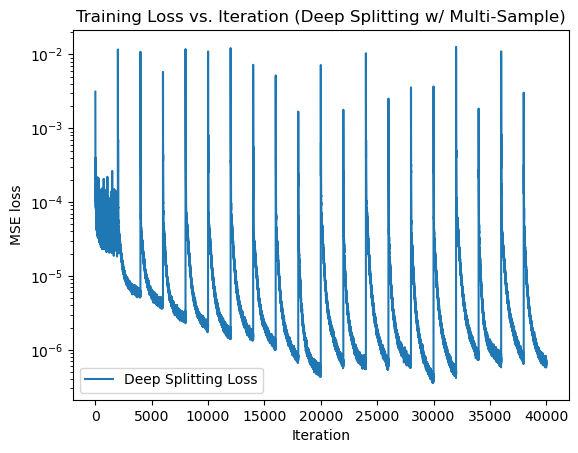

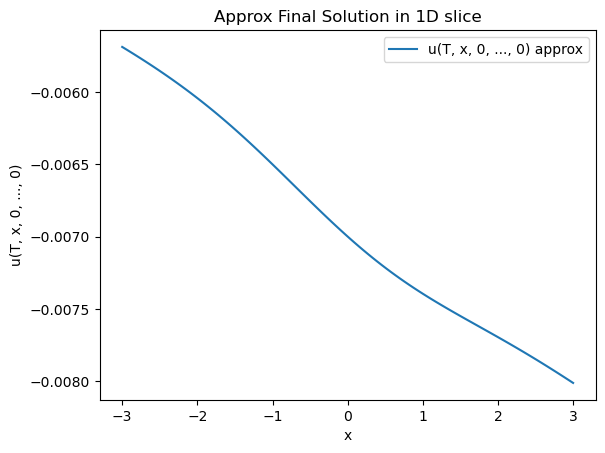

Saved predictions in dsm_approx_solutions.json


In [12]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import json
import math
import os

#======================================================================
#                    Device configuration
#======================================================================
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")
    device = torch.device("cpu")
else:
    device = torch.device("mps")

print("Using device:", device)

#-------------------------------------------------
#            1. Hyperparameters
#-------------------------------------------------
pde_dimension      = 10       # dimension of x
alpha              = 1.5      # fractional exponent
T                  = 1.0      # final time
N_time_steps       = 20       # number of time splits (increased from 10)
batch_size         = 1024     # batch size
lr_per_step        = 1e-4     # learning rate
epochs_per_step    = 2000     # epochs per time-split net (increased)
hidden_width       = 128      # width of hidden layers (increased)
n_hidden_layers    = 4        # deeper network
multi_sample_count = 5        # draw M>1 increments to reduce variance
max_grad_norm      = 1.0      # gradient clipping
CLAMP_VALUE        = 1e5      # clamp alpha-stable increments
EPS                = 1e-9     # small epsilon

#-------------------------------------------------
#   2. Generate alpha-stable increments in 10D
#-------------------------------------------------
def sample_alpha_stable(batch_size, dim, alpha, dt, device):
    """
    Return shape (batch_size, dim) of i.i.d. symmetric alpha-stable increments
    with 'time step' dt. We clamp outliers to avoid NaNs.
    """
    # alpha=2.0 -> Gaussian
    if abs(alpha - 2.0) < 1e-12:
        scale = math.sqrt(2.0 * dt)
        Y = scale * torch.randn(batch_size, dim, device=device)
        return torch.clamp(Y, -CLAMP_VALUE, CLAMP_VALUE)

    # alpha=1.0 -> Cauchy
    elif abs(alpha - 1.0) < 1e-12:
        U = torch.rand(batch_size, dim, device=device)
        Y = dt * torch.tan(math.pi * (U - 0.5))
        Y = torch.nan_to_num(Y, nan=0.0, posinf=CLAMP_VALUE, neginf=-CLAMP_VALUE)
        return torch.clamp(Y, -CLAMP_VALUE, CLAMP_VALUE)

    # alpha=1.5 -> Chambers–Mallows–Stuck
    elif abs(alpha - 1.5) < 1e-12:
        scale = (2.0 * dt) ** (1.0 / alpha)
        U = (torch.rand(batch_size, dim, device=device) - 0.5) * math.pi
        E = -torch.log(torch.rand(batch_size, dim, device=device) + EPS)

        cos_U = torch.cos(U)
        # clamp cos_U so we don't hit infinite
        cos_U = cos_U.clamp(min=-1.0+EPS, max=1.0-EPS)
        Z_num = torch.sin(alpha * U)

        # Denominator part = cos_U^(1/alpha)
        cos_part = cos_U.abs()**(1.0/alpha) * torch.sign(cos_U)**(1.0/alpha)

        # factor = [cos(U - alpha*U) / E]^((1-alpha)/alpha)
        cos_diff = torch.cos(U - alpha*U)
        cos_diff = torch.nan_to_num(cos_diff, nan=0.0, posinf=CLAMP_VALUE, neginf=-CLAMP_VALUE)
        ratio = cos_diff / (E + EPS)
        ratio = torch.clamp(ratio, -CLAMP_VALUE, CLAMP_VALUE)
        factor = ratio**((1.0 - alpha) / alpha)

        Z_den = cos_part + EPS
        Z = (Z_num / Z_den) * factor
        Z = torch.nan_to_num(Z, nan=0.0, posinf=CLAMP_VALUE, neginf=-CLAMP_VALUE)

        Y = scale * Z
        Y = torch.clamp(Y, -CLAMP_VALUE, CLAMP_VALUE)
        return Y

    else:
        raise NotImplementedError("sample_alpha_stable only handles alpha=1.0, 1.5, or 2.0.")

#-------------------------------------------------
# 3. Initial Condition
#    u(0,x) = exp( -||x||^2 )
#-------------------------------------------------
def initial_condition(x):
    return torch.exp(-torch.sum(x**2, dim=1, keepdim=True))

#-------------------------------------------------
# 4. Neural Nets (Deeper, Wider)
#-------------------------------------------------
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1, n_layers=4):
        super(MLP, self).__init__()
        layers = []
        # first layer
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.Tanh())
        # hidden layers
        for _ in range(n_layers-1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.Tanh())
        # final
        layers.append(nn.Linear(hidden_dim, output_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

# Create a list of networks: net[0] is a function (initial condition), net[1..N] are MLPs
nets = [None]*(N_time_steps+1)
nets[0] = initial_condition  # not an nn.Module, just a Python function

for k in range(1, N_time_steps+1):
    nets[k] = MLP(
        input_dim=pde_dimension,
        hidden_dim=hidden_width,
        output_dim=1,
        n_layers=n_hidden_layers
    ).to(device)

#-------------------------------------------------
# 5. Training Loop (Deep Splitting w/ Multi-Sample Expectation)
#-------------------------------------------------
time_grid = np.linspace(0, T, N_time_steps+1, dtype=np.float32)
dt = T / N_time_steps

training_losses = []

for k in range(N_time_steps):
    print(f"Training net[{k+1}], time ~ {time_grid[k+1]:.3f}")
    optimizer = torch.optim.Adam(nets[k+1].parameters(), lr=lr_per_step)

    for epoch in range(epochs_per_step):
        optimizer.zero_grad()

        # sample x ~ Normal(0,1)
        x_batch = torch.randn(batch_size, pde_dimension, device=device)

        # We want E[u_prev(x + Y)], but we do a multi-sample approach for variance reduction
        #  => For each x, draw M alpha-stable increments, evaluate net[k], average.
        # shape: (batch_size, pde_dimension)
        # We'll expand x_batch to (batch_size, 1, pde_dimension) => broadcast
        x_expanded = x_batch.unsqueeze(1)  # shape (batch_size, 1, pde_dimension)

        # We'll sample M increments and add them to x_expanded. shape => (batch_size, M, pde_dimension)
        Y_list = []
        M = multi_sample_count
        for _ in range(M):
            Y_i = sample_alpha_stable(batch_size, pde_dimension, alpha, dt, device).unsqueeze(1)
            Y_list.append(Y_i)
        # stack => shape (batch_size, M, pde_dimension)
        Y_stacked = torch.cat(Y_list, dim=1)

        x_plus_Y = x_expanded + Y_stacked  # shape (batch_size, M, pde_dimension)

        # Evaluate net[k] at x_plus_Y
        if k == 0:
            # net[0] is the initial condition (function)
            # So we must reshape x_plus_Y => (batch_size*M, pde_dimension) for a vectorized evaluation
            x_plus_Y_flat = x_plus_Y.view(batch_size*M, pde_dimension)
            u_prev_vals = nets[0](x_plus_Y_flat)  # shape (batch_size*M, 1)
        else:
            x_plus_Y_flat = x_plus_Y.view(batch_size*M, pde_dimension)
            u_prev_vals = nets[k](x_plus_Y_flat)  # shape (batch_size*M, 1)

        # Reshape back to (batch_size, M, 1)
        u_prev_vals = u_prev_vals.view(batch_size, M, 1)
        # Average over dimension=1 => shape (batch_size, 1)
        u_target = torch.mean(u_prev_vals, dim=1, keepdim=False).detach()

        # net[k+1](x_batch) => shape (batch_size, 1)
        u_new = nets[k+1](x_batch)
        loss = torch.mean((u_new - u_target)**2)

        if torch.isnan(loss):
            print(f"  [Warning] NaN loss at epoch={epoch}, skipping.")
            continue

        loss.backward()
        torch.nn.utils.clip_grad_norm_(nets[k+1].parameters(), max_grad_norm)
        optimizer.step()

        training_losses.append(loss.item())

        if (epoch+1) % 500 == 0:
            print(f"  Epoch {epoch+1}/{epochs_per_step}, Loss={loss.item():.5e}")

print("Deep Splitting training complete.")

#-------------------------------------------------
# 6. Plot the training loss
#-------------------------------------------------
plt.figure()
plt.plot(training_losses, label="Deep Splitting Loss")
plt.xlabel("Iteration")
plt.ylabel("MSE loss")
plt.yscale("log")
plt.title("Training Loss vs. Iteration (Deep Splitting w/ Multi-Sample)")
plt.legend()
plt.show()

#-------------------------------------------------
# 7. Evaluate final net in a 1D slice
#-------------------------------------------------
def evaluate_final_net_1d_slice(x_vals_1d):
    # shape => (N_points,)
    x_vals_1d = np.array(x_vals_1d, dtype=np.float32)
    # We'll build (N_points, pde_dimension) on device
    x_tensor = torch.zeros((len(x_vals_1d), pde_dimension), device=device, dtype=torch.float32)
    x_tensor[:, 0] = torch.from_numpy(x_vals_1d).to(device)

    # Evaluate final net
    with torch.no_grad():
        u_approx = nets[N_time_steps](x_tensor)  # shape (N_points, 1)
    return u_approx.cpu().numpy().ravel()

# quick check in 1D slice
x_range = np.linspace(-3, 3, 100, dtype=np.float32)
u_plot = evaluate_final_net_1d_slice(x_range)

plt.figure()
plt.plot(x_range, u_plot, label="u(T, x, 0, ..., 0) approx")
plt.title("Approx Final Solution in 1D slice")
plt.xlabel("x")
plt.ylabel("u(T, x, 0, ..., 0)")
plt.legend()
plt.show()

#-------------------------------------------------
# 8. Evaluate on test_data.json
#-------------------------------------------------
def approximate_solution_for_test_data(nets, dt,
                                       filename_in="test_data.json",
                                       filename_out="dsm_approx_solutions.json"):
    """
    Reads time (t) and spatial points (x) from 'test_data.json',
    evaluates the approximate solution for each (t_i, x_i),
    and saves the results into 'dsm_approx_solutions.json'.
    """
    import json

    with open(filename_in, "r") as f:
        test_data = json.load(f)

    t_list = np.array(test_data["t"], dtype=np.float32)   # shape (N,)
    x_list = np.array(test_data["x"], dtype=np.float32)   # shape (N, pde_dimension)

    solutions = np.zeros(len(t_list), dtype=np.float32)

    with torch.no_grad():
        for i in range(len(t_list)):
            # clamp index
            k = int(round(t_list[i] / dt))
            k = max(0, min(k, N_time_steps))

            x_torch = torch.from_numpy(x_list[i]).unsqueeze(0).float().to(device)
            # Evaluate
            if k == 0:
                val = nets[0](x_torch)
            else:
                val = nets[k](x_torch)

            solutions[i] = val.cpu().numpy().flatten()[0]

    out_dict = {"approx_solutions": solutions.tolist()}
    with open(filename_out, "w") as f:
        json.dump(out_dict, f, indent=2)

    return solutions

#-------------------------------------------------
# 9. Example usage
#-------------------------------------------------
if __name__ == "__main__":
    # Evaluate and save predictions
    preds = approximate_solution_for_test_data(
        nets=nets,
        dt=dt,
        filename_in="test_data.json",
        filename_out="dsm_approx_solutions.json"
    )
    print("Saved predictions in dsm_approx_solutions.json")
